# DLC-based Slipping/Falling Analysis

This repository contains code for analyzing the behavior of a mouse running on a rod using DeepLabCut (DLC) labeled data.

## Analysis

The analysis consists of the following steps:

1. Load the DLC labeled data to obtain the coordinates of the rods and the mouse's paws in all frames.
2. Determine whether the mouse is running on a rod, slipping off a rod, or falling off a rod.

## Settings

To use this code, you will need to adjust the following settings:

1. Change the `directory_path` and `file_name` variables to match the Google Drive you mounted and the name of the data file of the DLC labeled data, work for .xlsx and .csv files.
2. Adjust the `threshold_slip` and `threshold_miss` variables to fine-tune the detection of whether the mouse is running on a rod, slipping off a rod, or falling off a rod.

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


#### Settings and Utility Functions

In [7]:
directory_path = "./data/"
file_name = "CollectedData.xlsx"
threshold_slip = -2
threshold_miss = -40

#figure setting
linewidth = 3
def getRodLine(dataframe):
  '''
  Select columns that start with 'rod' and then get the even-numbered 
  and odd-numbered columns for the x and y coordinates respectively.
  '''
  x = df.loc[:, df.columns.str.startswith('rod')].iloc[:, ::2].values.reshape(-1, 1)
  y = df.loc[:, df.columns.str.startswith('rod')].iloc[:, 1::2].values.reshape(-1, 1)
  
  # Fit a linear model to x and y to obtain a straight line of the rod.
  model = LinearRegression()
  model.fit(x,y)
  return model
  
def getStatus(x, y, linear_model):
  slope = linear_model.coef_[0]
  intercept = linear_model.intercept_
  y_on_line = slope*x + intercept
  distance = (y - y_on_line)[0]
  if  distance<= threshold_slip:
    if distance >= threshold_miss:
      return (distance, "slip")
    else:
      return (distance, "miss")
  else:
      return (distance, "good")

def count_slip_miss(paw_stat):
  # number of slip and miss
  prev_v, count_slip, count_miss = "good", 0, 0
  total = len(paw_stat)
  for v in paw_stat.values:
    if v == "slip" and prev_v == "good":
      count_slip +=1
    elif v == "miss":
      if prev_v == "slip":
        count_miss +=1
      elif prev_v == "good":
        count_slip +=1
        count_miss +=1
  return count_slip, count_miss, round((count_slip/total) * 100,3), round((count_miss/total) * 100,3)

def behavior_plot(df):
  paw_stat_count = {"paw":[], "num_slip":[], "num_miss":[], "prec_slip":[], "prec_miss":[]}
  for paw in ["front_left", "front_right", "back_left", "back_right"]:
    paw_stat_count["paw"].append(paw)
    count_slip, count_miss, percent_slip, percent_miss = count_slip_miss(df_behavior[paw+".stat"])
    paw_stat_count["num_slip"].append(count_slip)
    paw_stat_count["num_miss"].append(count_miss)
    paw_stat_count["prec_slip"].append(f"{percent_slip} %")
    paw_stat_count["prec_miss"].append(f"{percent_miss} %")
  df_stat_count = pd.DataFrame(paw_stat_count)
  display(df_stat_count)
  fig, ax = plt.subplots(figsize=(25,4))
  sns.lineplot(x=df.index, y='front_left.dist', data=df, ax=ax, label='front_left', linewidth = linewidth, color = "#4B6D9A")
  sns.lineplot(x=df.index, y='front_right.dist', data=df, ax=ax, label='front_right', linewidth = linewidth, color = "#2A4B7C")
  sns.lineplot(x=df.index, y='back_left.dist', data=df, ax=ax, label='back_left', linewidth = linewidth, color = "#66c2a5")
  sns.lineplot(x=df.index, y='back_right.dist', data=df, ax=ax, label='back_right', linewidth = linewidth, color = "#2E8540")
  ax.set_title(f'Tracking the Behavior of a Mouse: Time Series Analysis')
  ax.set_xlabel('Frames')
  ax.set_ylabel('Distance between paw and rod line')
  ax.legend()
  ax.axhline(y=threshold_slip, color='#FF5733', linewidth = linewidth, linestyle='--')
  ax.axhline(y=threshold_miss, color='#C70039', linewidth = linewidth, linestyle='--')
  plt.show()

#### Load data & Data preprocessing




In [8]:
file_path = os.path.join(directory_path, file_name)
if file_name.endswith('.xlsx'):
  data_file = pd.ExcelFile(file_path)
  df = pd.read_excel(data_file, header=1).dropna().iloc[:,3:].astype(float).reset_index(drop=True)
else:
  df = pd.read_csv(file_path, header=1).dropna().iloc[:,3:].astype(float).reset_index(drop=True)
df.head(n=5)

,frontpawleft,frontpawleft.1,frontpawright,frontpawright.1,backpawleft,backpawleft.1,backpawright,backpawright.1,rodone,rodone.1,rodtwo,rodtwo.1,rodthree,rodthree.1,rodfour,rodfour.1,rodfive,rodfive.1
0,879.737389,652.008012,655.405045,647.735015,1315.583086,797.289911,1089.114243,666.963501,1601.873887,673.372997,1274.989614,686.191988,903.238872,701.147478,563.535608,709.693472,202.467359,718.239466
1,1007.927300,707.556973,804.959941,675.509496,1048.520772,914.797329,1249.351632,694.737982,1473.683976,669.100000,1129.707715,679.782493,755.820475,703.283976,386.206231,703.283976,57.185460,709.693472
2,1313.373644,522.501659,1258.695916,664.020485,1472.582323,615.775431,1419.512763,606.126420,1784.567007,647.938800,1464.541481,662.412317,1123.609764,670.453159,777.853542,689.751181,395.109445,691.359349
3,824.490428,643.114295,980.482770,691.359349,1279.602106,697.792023,1083.405552,639.897958,1827.987556,643.114295,1517.611040,654.371474,1168.638481,662.412317,824.490428,683.318507,448.179004,683.318507
4,810.016911,607.734588,591.305999,578.787556,1266.736758,787.849458,1044.809509,578.787556,1834.420230,582.003893,1503.137524,601.301914,1154.164965,607.734588,790.718890,620.599936,403.150287,631.857116


#### Calculate the distance between each paw and the rod line.

In [9]:
linear_model_rod = getRodLine(df)
col_distances_status = ['front_left.dist','front_left.stat','front_right.dist','front_right.stat','back_left.dist','back_left.stat','back_right.dist','back_right.stat']
df[col_distances_status] = 0
df[["front_left.dist",'front_left.stat']] = df.apply(lambda row: getStatus(row["frontpawleft"], row["frontpawleft.1"], linear_model_rod), axis=1, result_type='expand')
df[["front_right.dist",'front_right.stat']] = df.apply(lambda row: getStatus(row["frontpawright"], row["frontpawright.1"], linear_model_rod), axis=1, result_type='expand')
df[["back_left.dist",'back_left.stat']] = df.apply(lambda row: getStatus(row["backpawleft"], row["backpawleft.1"], linear_model_rod), axis=1, result_type='expand')
df[["back_right.dist",'back_right.stat']] = df.apply(lambda row: getStatus(row["backpawright"], row["backpawright.1"], linear_model_rod), axis=1, result_type='expand')
df_behavior = df.loc[:,col_distances_status]
display(df_behavior)




,front_left.dist,front_left.stat,front_right.dist,front_right.stat,back_left.dist,back_left.stat,back_right.dist,back_right.stat
0,83.918822,good,73.185238,good,241.752717,good,104.904192,good
1,143.159547,good,105.266776,good,351.568961,good,137.293377,good
2,-33.099165,slip,106.844988,good,64.759685,good,53.582315,good
3,73.434038,good,126.171543,good,141.218607,good,77.674243,good
4,37.637506,good,2.391779,good,230.905530,good,15.452306,good
...,...,...,...,...,...,...,...,...
106,-72.811557,miss,-43.529307,miss,-76.888185,miss,-42.047360,miss
107,-67.197053,miss,-47.260185,miss,-65.890327,miss,-57.126538,miss
108,-64.230421,miss,-82.407647,miss,-53.697603,miss,-61.227414,miss
109,-74.819168,miss,-87.298972,miss,-130.779602,miss,-63.984407,miss


#### Plots

,paw,num_slip,num_miss,prec_slip,prec_miss
0,front_left,91,34,81.982 %,30.631 %
1,front_right,104,64,93.694 %,57.658 %
2,back_left,56,32,50.45 %,28.829 %
3,back_right,80,34,72.072 %,30.631 %


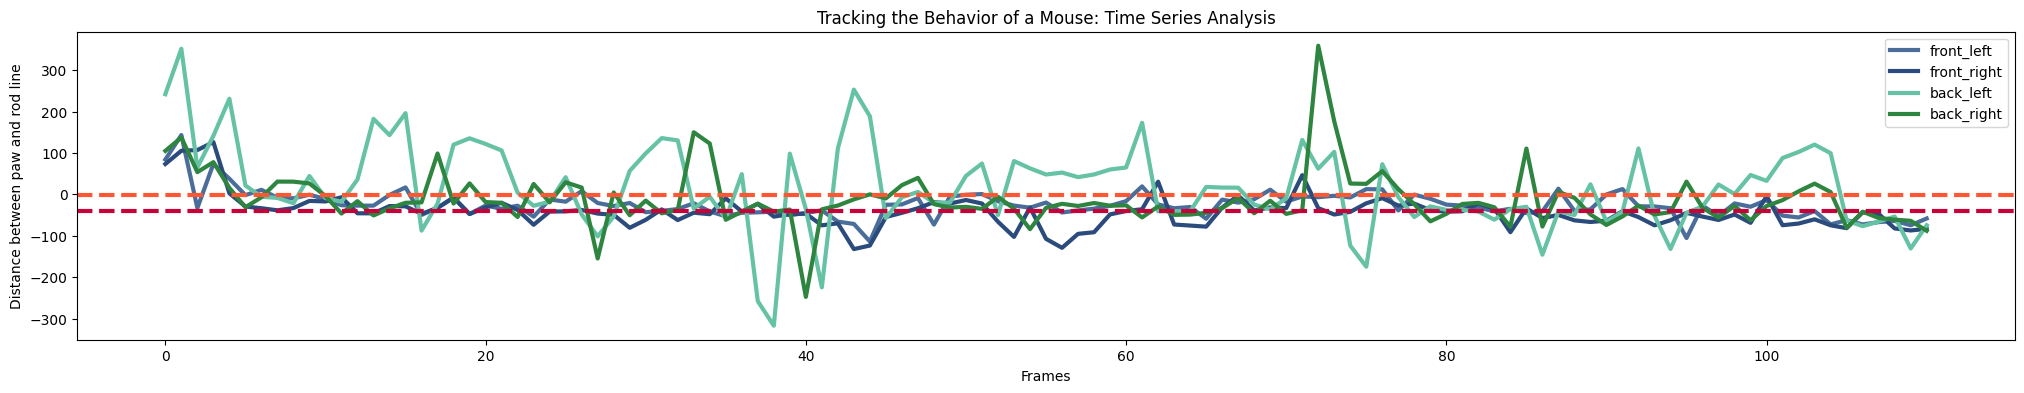

In [10]:
behavior_plot(df_behavior)